# Scrapping data for sentiment analysis

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import time
from webdriver_manager.microsoft import EdgeChromiumDriverManager
import pandas as pd


#Replaced chromedriver with edgedriver
driver = webdriver.Edge(service=Service(EdgeChromiumDriverManager().install()))

driver.get("https://www.rottentomatoes.com/m/black_panther_2018/reviews")
reviewText=[]


# Creates "load more" button object.
wait = WebDriverWait(driver, 10)
load_more_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//*[@id='reviews']/div[3]/rt-button[2]")))

while True:
    try:
        page_source = driver.page_source
        soup = bs(page_source, 'html.parser')
        
        reviewTable = soup.find("div", {"class": "review_table"})
        reviewText += [t.get_text() for t in reviewTable.select(".review-row .review-text")]
        load_more_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//*[@id='reviews']/div[3]/rt-button[2]")))
        load_more_button.click()
        time.sleep(5)
    except:
        break

#close the browser
driver.quit()

#Creating a pandas database
df = pd.DataFrame(reviewText, columns=['Review'])
print(df)

#Saving Data, so we don't have to scrpae again 
df.to_csv('./Fresh_Data.csv', index=False)

In [1]:
#Loading the scraped data 
import pandas as pd

df = pd.read_csv('./Fresh_Data.csv')
print(df)

                                                Review
0    Marvel movies proved they could keep on evolvi...
1    A heady mix of William Shakespeare and Walt Di...
2    [The film's] central struggle is one that you ...
3    Wakanda Forever is the big screen outing that ...
4    But “Black Panther” isn’t just a cultural stat...
..                                                 ...
526  It's gripping, funny, and full of spectacle, b...
527  Not everything about Black Panther works acros...
528  Ryan Coogler's superhero adventure is a crowd-...
529  While many Marvel films feel like small pieces...
530  Innovative, intelligent and empowering. When I...

[531 rows x 1 columns]


# Data Cleaning

In [2]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from tqdm import tqdm

#nltk.download('stopwords')

stemmer = PorterStemmer()

# List of all the stop words, we will remove.
all_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those']

corpus = []
pos_corpus = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    sent = re.sub('[^a-zA-Z]', ' ', row['Review']) #Dropping Special Charecters
    sent = sent.lower()  #Case Normalization
    sent = word_tokenize(sent) #Tokenization
    sent = [word for word in sent if word not in all_stopwords] #Removing Stopwords
    sent = [stemmer.stem(word) for word in sent] #Stemming 
    #pos_sent = pos_tag(sent) #Adding POS Tag
    #pos_corpus.append(pos_sent)
    sent = ' '.join(sent)
    corpus.append(sent)

100%|███████████████████████████████████████████████████████████████████████████████| 531/531 [00:00<00:00, 651.68it/s]


# Data Transformation
### Converting everything to vectors.

In [3]:
import spacy #Used for vec
nlp = spacy.load("en_core_web_md")

In [4]:
X = []
for sent in tqdm(corpus, total = len(corpus)):
    doc = nlp(sent)
    vector = doc.vector
    X.append(vector)

100%|████████████████████████████████████████████████████████████████████████████████| 531/531 [00:11<00:00, 47.95it/s]


# Predictions

In [5]:
import joblib
classifier = joblib.load('./Classifier_Sentiment_Model')

In [6]:
y_pred = classifier.predict(X)

In [7]:
df['Predicted Label'] = y_pred.tolist()

# Saving Output

In [8]:
df.to_csv("./Sentiment_Analysis_Output.csv", sep='\t', encoding='UTF-8', index=False)

In [9]:
print(df)

                                                Review Predicted Label
0    Marvel movies proved they could keep on evolvi...        positive
1    A heady mix of William Shakespeare and Walt Di...        positive
2    [The film's] central struggle is one that you ...        positive
3    Wakanda Forever is the big screen outing that ...        positive
4    But “Black Panther” isn’t just a cultural stat...        positive
..                                                 ...             ...
526  It's gripping, funny, and full of spectacle, b...        negative
527  Not everything about Black Panther works acros...        positive
528  Ryan Coogler's superhero adventure is a crowd-...        positive
529  While many Marvel films feel like small pieces...        positive
530  Innovative, intelligent and empowering. When I...        positive

[531 rows x 2 columns]


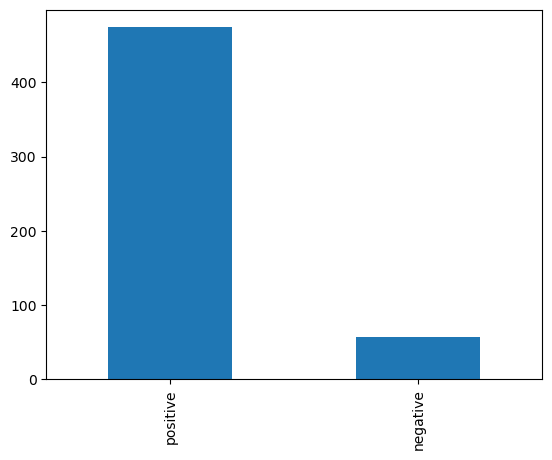

In [10]:
import matplotlib.pyplot as plt

df['Predicted Label'].value_counts().plot(kind='bar')
plt.show()